## Using Lets-Plot with GeoPandas to Create Maps

GeoPandas **GeoDataFrame** is a tabular data structure that contains a set of shapes (*geometry*) per each observation.

*GeoDataFrame* extends pandas *DataFrame* and as such, aside from the *geometry*, can contain other data.

GeoPandas has three basic classes of geometric objects (shapes):

- Points / Multi-Points
- Lines / Multi-Lines
- Polygons / Multi-Polygons

All GeoPandas shapes are "undersood" by *Lets-Plot* and can be plotted using various geometry layers, depending on the type of the shape. 

Use: 

- *geom_point, geom_text* with Points / Multi-Points
- *geom_path* with Lines / Multi-Lines
- *geom_polygon, geom_map* with Polygons / Multi-Polygons 
- *geom_rect* when used with Polygon shapes will display corresponding bounding boxes



In [1]:
import geopandas as gpd

from lets_plot import *


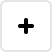
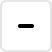
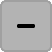
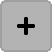
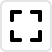
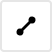
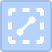
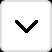
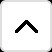
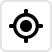
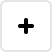
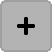
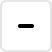
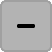
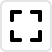
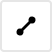
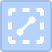
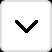
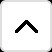
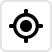

In [2]:
LetsPlot.setup_html()

In [3]:
def get_naturalearth_data(data_type="admin_0_countries", columns=["NAME", "geometry"]):
    import shapefile
    from shapely.geometry import shape

    naturalearth_url = "https://raw.githubusercontent.com/JetBrains/lets-plot-docs/master/" + \
                       "data/naturalearth/{0}/data.shp?raw=true".format(data_type)
    sf = shapefile.Reader(naturalearth_url)

    gdf = gpd.GeoDataFrame(
        [
            dict(zip([field[0] for field in sf.fields[1:]], record))
            for record in sf.records()
        ],
        geometry=[shape(s) for s in sf.shapes()]
    )[columns]
    gdf.columns = [col.lower() for col in gdf.columns]

    return gdf

### Polygon shapes - Naturalearth low-resolution world dataset.

In [4]:
world = get_naturalearth_data(columns=["NAME", "ISO_A3", "CONTINENT", "POP_EST", "GDP_MD", "geometry"])
world.head()

name iso_a3      continent      pop_est    gdp_md  \
0                      Fiji    FJI        Oceania     889953.0      5496   
1                  Tanzania    TZA         Africa   58005463.0     63177   
2                 W. Sahara    ESH         Africa     603253.0       907   
3                    Canada    CAN  North America   37589262.0   1736425   
4  United States of America    USA  North America  328239523.0  21433226   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [5]:
world.continent.unique()

array(['Oceania', 'Africa', 'North America', 'Asia', 'South America',
       'Europe', 'Seven seas (open ocean)', 'Antarctica'], dtype=object)

#### *geom_polygon()*

In [6]:
# Use parameter `map` in `geom_polygon` to display Polygons / Multi-Polygons 
(ggplot() 
 + geom_polygon(map=world, fill='white', color='gray') 
 + ggsize(700, 400) 
 + theme_void()
)

#### geom_map()

*geom_map()* is very similar to *geom_polygon()* but it automatically applies `Mercator` projection and other defaults that are more suitable for displaying blank maps. 

In [7]:
(ggplot() 
 + geom_map(map=world) 
 + ggsize(700, 400) 
 + theme_void()
)

In [8]:
# When applying Mercator projection to the world map, Antarctica becomes disproportionally large so 
# in the future lets show only part of it above 85th parallel south:
world_limits = coord_map(ylim=[-70, 85])

### Point shapes - Naturalearth world capitals dataset.

In [9]:
cities = get_naturalearth_data(data_type="populated_places")
cities.head()

name                    geometry
0  Vatican City   POINT (12.45339 41.90328)
1    San Marino   POINT (12.44177 43.93610)
2         Vaduz    POINT (9.51667 47.13372)
3       Lobamba  POINT (31.20000 -26.46667)
4    Luxembourg    POINT (6.13000 49.61166)

#### geom_point()

In [10]:
# Use parameter `map` in `geom_point` to display Point shapes
(ggplot()
 + geom_map(map=world)
 + geom_point(map=cities, color='red')
 + ggsize(800, 600) + theme_void() + world_limits
) 

### geom_text()

The situation with *geom_text* is different because in order to display labels we have to specify mapping for the aesthetic "label".

Aesthetic mapping binds a variable in *data* (passed via the `data` parameter) with its representation on the screen.

Variables in GeoDataframe passed via the `map` parameter can not be used in the aesthetic mapping.

Fortunately, such a GeoDataframe can as well be passed via the `data` parameter and Lets-Plot will undersand that its *geometries* should be mapped to the "x" and "y" aesthetic automatically.

In the next example we are going to show names of cities as labels on map. 

Let's show only South American capitals because too many labels on the entire world map would quickly become not legible.

In [11]:
# Obtain bounding box of South America and use it to set the limits.
south_am = world[world.continent == 'South America']
south_am_bounds = south_am.geometry.total_bounds

# Let's use slightly expanded boundind box.
from shapely.geometry import box
south_am_box = box(*south_am_bounds).buffer(4)

south_am_limits = coord_map(xlim=south_am_box.bounds[0::2], ylim=south_am_box.bounds[1::2])


(ggplot() 
 + geom_map(map=south_am) 
 + geom_rect(map=gpd.GeoDataFrame({'geometry' : [south_am_box]}), alpha=0, color="#EFC623"))


In [12]:
# Add `text` layer and use its `data` parameter to pass the `cities` GeoDataFrame.
# Also configure tooltip in the points layer to show the city name.
(ggplot()
 + geom_map(map=south_am, fill="#e5f5e0")
 + geom_point(data=cities, color='red', size=3, tooltips=layer_tooltips().line("@name"))
 + geom_text(aes(label='name'), data=cities, vjust=1, position=position_nudge(y=-.2))
 + geom_rect(map=gpd.GeoDataFrame({'geometry' : [south_am_box]}), alpha=0, color="#EFC623", size=16)
 + south_am_limits
 + ggsize(450, 691)
 + theme_void()
) 

### Choropleth

As we saw earlier, *Lets-Plot* geom-layers accept *GeoDataFrame* in their `data` parameter. 

This makes it easy to bind aesthetics with variables in *GeoDataFrame*.

In [13]:
# Create a choropleth by mapping the `continent` variable to the `fill` aesthetic.
(ggplot() 
 + geom_map(aes(fill='continent'), data=world, color='white') 
 + world_limits
 + ggsize(900, 400) + theme_void()
)

In [14]:
# Create another choropleth by mapping the `GDP estimate` variable to the `fill` aesthetic.
(ggplot() 
 + geom_map(aes(fill='gdp_md'), data=world, color="white")
 + scale_fill_continuous(format='~s')
 + world_limits
 + ggsize(800, 400) + theme_void()
)

### Joining `data` and `geometry` datasets

In this example we will use both: the `data` and the `map` parameters.

We will use the `data` parameter to pass "average temperature per continent" dataset to the geom layer.

The continent geometries *GeoDataFrame* is passed via the `map` parameter as before.

For this to work it is also necessary to specify fields by which *Lets-Plot* will join `data` and `map` datasets. We will do that using the *map_join* parameter.

In [15]:
# Average temperatures by continent (fictional)
climat_data = dict(
    region = ['Europe', 'Asia', 'North America', 'Africa', 'Australia', 'Oceania'],
    avg_temp = [8.6, 16.6, 11.7, 21.9, 14.9, 23.9]
)

In [16]:
# Join `data` and `map` using the `map_join` parameter.
# For the sake of the demo let's use `geom_rect` and customize the tooltip.
(ggplot()
 + geom_rect(aes(fill='avg_temp'), 
             data=climat_data, 
             map=world, map_join=[['region'], ['continent']], 
             color="white",
             tooltips=layer_tooltips().line("^fill C\u00b0"))
 + scale_fill_gradient(low='light_blue', high="dark_green", name="Average t[C\u00b0]")
 + ggsize(800, 400) + theme_void()
) 